In [53]:
%matplotlib inline
import xgboost as xgb
import matplotlib.pylab as plt
import seaborn as sns

In [70]:
import pandas as pd
import numpy as np
import scipy.sparse as ssp

from DSI_Capstone_Steemit.utils.utils import(
    load_data_and_description,
)
from sklearn.model_selection import train_test_split


data,feature_names,data_desc = load_data_and_description(data_type='posts_tfidf')
data_desc['log total_payout_value'] = np.log(data_desc['total_payout_value'])

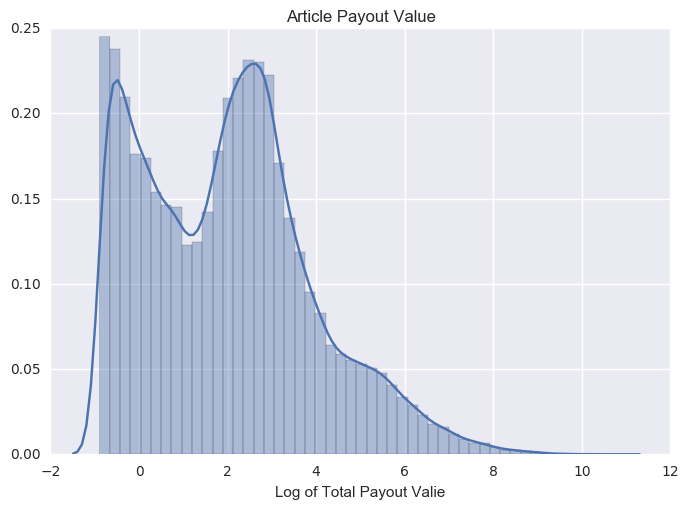

In [72]:
sns.distplot(data_desc['log total_payout_value'])
plt.xlabel('Log of Total Payout Valie')
plt.title('Article Payout Value')

In [2]:




# Remove middle value articles

idx1 = data_desc['log total_payout_value'] < 1.2
idx2 = data_desc['log total_payout_value'] >2.5

idx_not = (~idx1) & (~idx2)

data_desc = data_desc[~idx_not]
data = data[~idx_not.values,:]
y = data_desc['log total_payout_value'] >2.5

value_counts = data_desc['category'].value_counts()
top_categories = value_counts.index[value_counts > np.percentile(data_desc['category'].value_counts(),97)]
idx = data_desc['category'].isin(top_categories)
data_desc['top category'] = idx.astype(int)

data_desc['top category listed'] = data_desc.ix[data_desc['top category'].values.astype(bool) ,'category']

data_desc['top category listed'] = data_desc['top category listed'].fillna('Other')

train_features = data_desc.ix[:,['number of body tags',
                                   'number of body urls',
                                   'number of image urls',
                                   'number of body mentions',
                                   'number of image urls',
                                   'number of youtube urls',
                                   'language',
                                   'author_reputation_scaled',
                                   'number of steem counts',
                                'top category']]


train = pd.get_dummies(train_features)

num_image_urls = train['number of image urls'].values[:,0]
train.drop('number of image urls',axis = 1, inplace=True)

train['number of image urls'] = num_image_urls

training_names = train.columns

train_sparse = ssp.csr_matrix(train)
new_data = ssp.hstack([data,train_sparse])
train = new_data.tocsr()

# All samples
number_of_samples = train.shape[0]


import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


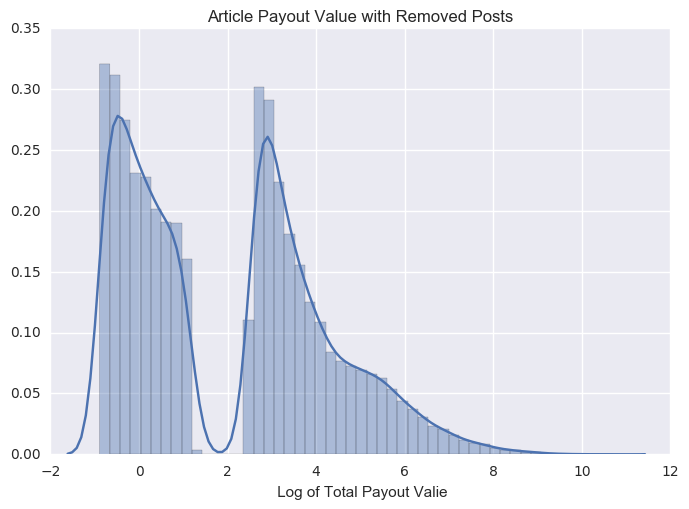

In [69]:
sns.distplot(data_desc['log total_payout_value'])
plt.xlabel(' Log of Total Payout Valie')
plt.title('Article Payout Value with Removed Posts')

In [4]:
cv_results = pd.read_csv('../data/xgboost_cv/results.csv')

In [10]:
cv_results = cv_results.sort_values('mean_test_score',ascending=False).reset_index(drop = True)

In [19]:
import json

import json
s = cv_results.ix[0,'params']
json_acceptable_string = s.replace("'", "\"")
d = json.loads(json_acceptable_string)


In [26]:
type(d['max_depth'])

int

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    train, y, test_size=0.10, random_state=42)


xgbc = XGBClassifier(**d)

In [30]:
xgbc.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=7,
       min_child_weight=3, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0.1, reg_lambda=0.1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [43]:
y_test.values

array([ True,  True, False, ...,  True, False, False], dtype=bool)

In [46]:
score = xgbc.score(X_test,y_test)
probabilities = xgbc.predict_proba(X_test)
predictions = xgbc.predict(X_test)

In [66]:
pd.Series(y_test).astype(int).value_counts()

1    4276
0    4218
Name: log total_payout_value, dtype: int64

In [68]:
print (4276 + 0.0) /len(y_test) 
print (4218 + 0.0) /len(y_test) 

0.503414174712
0.496585825288


In [47]:
all_features = list(feature_names) + list(training_names)

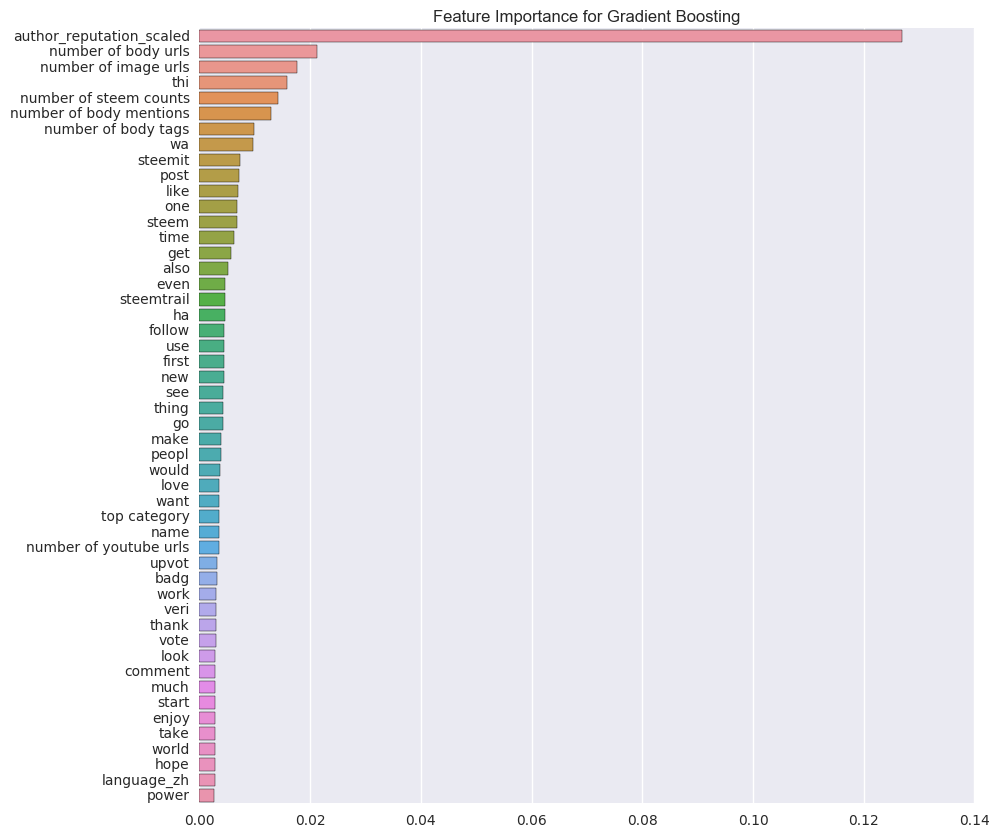

In [55]:
sort_order = np.argsort(xgbc.feature_importances_)[::-1]
features_ordered = np.array(all_features)[sort_order]
values_ordered = xgbc.feature_importances_[sort_order]
top = 50
fig,ax = plt.subplots(1,1,figsize = (10,10))
sns.barplot(x = values_ordered[0:top],y = features_ordered[0:top], ax = ax)
ax.set_title('Feature Importance for Gradient Boosting')

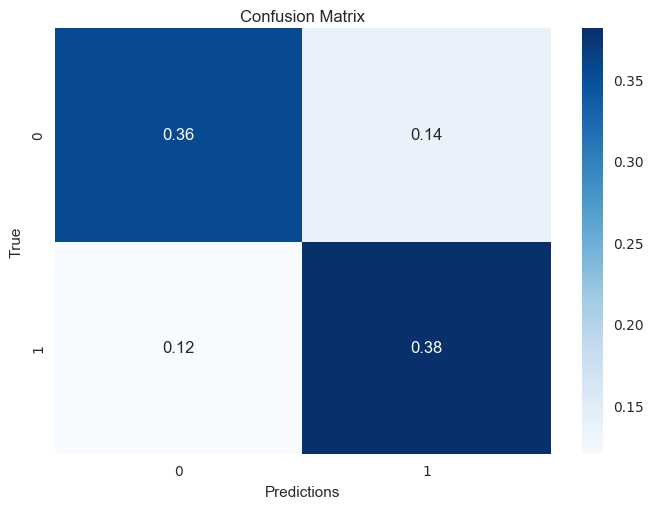

In [62]:
from sklearn.metrics import confusion_matrix
cm =  confusion_matrix(y_pred=predictions, y_true=y_test)
cm_normal = (cm + 0.0)/len(y_test)
sns.heatmap(cm_normal,cmap='Blues', annot=True,xticklabels=[0,1],yticklabels=[0,1],
            fmt='.2f')
plt.title('Confusion Matrix')
plt.xlabel('Predictions')
plt.ylabel('True')
plt.savefig('Confusion Matrix.png')